## Import Libraries

In [1]:
# !pip install vaderSentiment

# Ignore warnings :
import warnings
warnings.filterwarnings('ignore')

## Basics
import random
import scipy as sp
import numpy as np
import pandas as pd
import json
import gc


# Modeling
from tensorflow import keras
from tensorflow.keras import optimizers
from keras import models, layers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
# from sklearn.feature_selection import RFECV
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# from sklearn.decomposition import PCA

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 200

%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amp-music/meta_Digital_Music.json
/kaggle/input/amp-music/Digital_Music.json


# Deep Learning with Keras for Recommendation Systems - Digital Music
### Author: Annetta Zheng

Dataset Source: http://deepyeti.ucsd.edu/jianmo/amazon/

Citation: Justifying recommendations using distantly-labeled reviews and fined-grained aspects (Ni,Li, McAuley, 2019)

Note: Since the datasets are too large and as a music lover, I pick only one category - Digital Music - to implement the Recommendation System.

## Overview
#### 1. Introduction and Background
#### 2. Process Amazon Review Data from the Amazon Review Dataset (2018)
#### 3. EDA for Collaborative Filtering
#### 4. Applied Sentiment Analysis on Reviews
#### 5. Neural Network Collaborative Filtering built from Tensorflow/Keras

## 0) Introduction 

### Why do we need Recommendation Systems?

* Recommendation System helps to reduce Costs and increase Revenues of the product's organization, by targeting and fulfilling the business' goal in the AARRR Model, Consumer Segmentation, Ad Targeting, etc. 
* For instance, if we are looking to buy a new album on the Internet, our recent searches are based on music suggestions, and soon we will start seeing ads on websites offering discounts on albums or new songs.
* Marketing is an advertisement technique meant to deliver ads automatically by using specialized software and algorithms that place ads depending on the user’s recent searches.
* Streamlining is also vital for a company to use Recommendation Systems. There are also some good music which may be really good but have not gained popularity since they have not been advertised, so recommendation systems help such items gain popularity by bringing such items to one's notice.



### Types of recommendations
There are mainly 4 types of the recommendations systems:
- Demographic Filtering
    - They offer generalized recommendations to every user, based on movie popularity and/or genre. The System recommends the same movies to users with similar demographic features. Since each user is different, this approach is considered to be too simple. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience.
- Collaberative Filtering:
    - It is based on gathering and analyzing data on user’s behavior. This includes that people like things similar to other things they like, and things that are liked by other people with similar taste. It is mainly of two types: a) User-User b) Item-Item
- Content-Based Filtering:
    - It is based on the description of a product and a profile of the user’s preferred choices. It uses the information on the contents of the item rather than on the user opinions. This system uses item metadata, such as genre, description, singers, etc. for music to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.
- Hybrid System:
    - This system approach is to combine collaborative filtering, content-based filtering, and other approaches.

## Note: After EDA (in the following code section), I pick Item-Item Collaborative Filtering and Review-Based Filtering based on the metrics in our dataset.

### Collaborative Filtering (CF)

#### 1) User-User Collaborative Filtering 
- In this we we calculate similarity of all the users to the active user ( the user whom the prediction is for ).Then sort and filter the Top-N users to make predictions for the active user. This is usually very effective but takes a lot of time and resources. For example if Dennis and Davis like the same movies and a new movie comes out that Davis likes,then we can recommend that movie to Dennis because Davis and Dennis seem to like the same movies.

#### 2) Item-Item Collaborative Filtering 
- This is similar to User-User CF, just that we now compute similarity between items to recommend similar items. Eg. When you buy any product on Amazon, you will find this line "Users who bought this item also bought...", so Amazon uses item-item CF widely, Mind that I'm not saying they use only item-item CF, they have hybrid techniques to better suit users of even unique interests.

Item-Item CF are a lot faster than User-User CF. and secondly user profiles changes quickly and the entire system model has to be recomputed, whereas item's average ratings doesn't change that quickly, and this leads to more stable rating distributions in the model, so the model doesn't have to be rebuilt as often.

#### How do we calculate similarity?

There are many measures to calculate the similarity matrix, some of them are:

1) Jaccard Similarity - It is a statistic used for comparing the similarity and diversity of sample sets. It is defined as the size of the intersection divided by the size of the union of the sample sets.

2) Cosine Similarity - It measures the angle between the ratings vector. If the angle is 0°, then they are vectors having same orientation and if the angle is 180°, then they are highly dissimilar vectors.

3) Pearson Similarity - It is actually Centered-Cosine similarity. We subtract the mean ratings from the user ratings, so that the mean is centered at 0, and then calculate the cosine similarity.

## 1) Preprocessing Data

##### After Preprocessing and Cleaning, the Amazon review dataset on Music contains 182826 data samples and 14 useful features; I later train the models on 70% of the dataset and test the performance of the models on the remaining 30% of the dataset.

* Music: 'asin','style','title','brand', 'rank','price','overall_mean','overall_median','overall_count'
* User Review: 'asin','reviewerID','overall','reviewText','summary','day_of_week'

<!--   ,'also_buy', , 'also_view', , 'buy_count', 'view_count',  -->

##### The first dataset about music contains the following features:

* asin - A unique identifier for each album.
* title -  The name of the album.
* price - The price of the album.
* rank - The rank of this album.
* brand - The singer of this album.
* also_buy - The most popular albums the buyers also buy.
* also_view - The most popular albums the buyers also view.

In [2]:
# read and process products
meta = pd.read_json('../input/amp-music/meta_Digital_Music.json', lines=True)
meta =  meta.drop(['category', 'tech1','fit','tech2','imageURL','imageURLHighRes','description','main_cat','similar_item','feature','date', 'details'], axis = 1)
meta['rank'] = meta['rank'].astype(str).str.extract("(\d+,*\d+)")
meta['rank'] = pd.to_numeric(meta['rank'].str.replace('\,',''), errors='coerce')
meta['price'] = pd.to_numeric(meta['price'].str.replace('\$',''), errors='coerce')
meta['buy_count'] = meta['also_buy'].str.len()
meta['view_count'] = meta['also_view'].str.len()
meta['brand']  = meta['brand'].fillna('').str.lower()
# meta['main_cat'] = meta['main_cat'].astype(str).str.extract("alt\=\"(\w+\s*\w+)")

In [3]:
meta

,title,also_buy,brand,rank,also_view,price,asin,buy_count,view_count
0,Master Collection Volume One,"[B000002UEN, B000008LD5, B01J804JKE, 7474034352, B004ZLBTXW, B000008LDH, B000TGKXJ8, B0000AM6KG, B0001XJ372, B001CFLHMC, B0007VO57G, B000005KVI, B0000251O2, B07FDMZ233, B000008LD9, B000008LDL, 000...",john michael talbot,58291.0,"[B000002UEN, B000008LD5, 7474034352, B000008LDH, B004ZLBTXW, B0001XJ372, B001CFLHMC, B01J804JKE, B000008LDC, B000TGKXJ8, 0819815802, B0007VO57G, B0000AM6KG, B000CD3LOM, B0000251O2, B000008LDL, B00...",18.99,0001377647,43,33
1,Hymns Collection: Hymns 1 &amp; 2,"[5558154950, B00014K5V4]",second chapter of acts,93164.0,"[B000008KJ3, B000008KJ0, 5558154950, B000UN8KZE, B000008KJ4]",NaN,0001529145,2,5
2,Early Works - Don Francisco,"[B00004RC05, B003H8F4NA, B003ZFVHPO, B003JMP1ZK, B00000E8IS, B0000288OZ, 0760135886, B00125WECY, B000YQ2IOQ, B00007E8O0, B00111KUXY, B0002BARHI, B006R6Q6EU, B000075A86]",don francisco,875825.0,"[B003H8F4NA, B003ZFVHPO, B003JMP1ZK, B00004RC05, 0760135886, B00007E8O0, B000YQ2IOQ, B00125WECY, B00111KUXY]",NaN,0001527134,14,9
3,So You Wanna Go Back to Egypt,"[B0000275QQ, 0001393774, 0001388312, B0016CP2GS, B00P826ZRM, 1595551646, B0001YY7P4, B00000I7JO, B00000I9AH, B0000047XZ, B000075A86, B07896NHMK, B0002EZZMC, B0000031DI, B000008KJ8, 0793579805]",keith green,203263.0,"[B00000I7JO, B0016CP2GS, 0001393774, B0000275QQ, B00000I9AH, B0001YY7P4, B0002EZZMC, B00P826ZRM, B000OJKH78, B000075A86, B00412UE18, B000000V4U]",13.01,0001388703,16,12
4,Early Works - Dallas Holm,"[B0002N4JP2, 0760131694, B00002EQ79, B00150K8JC, B00007E8SE, B00000387A, B000I0QKB0, B000025Q0M, B000008QP3, B000FAMYIG, B0009WA252, B0016CP2GS, B016E9NE9Y, B000002UEN, B000T5MJN2, B003H8F4NA, B00...",dallas holm,399269.0,"[B0002N4JP2, 0760131694, B00150K8JC, B003MTXNVE, B00007E8SE, B00000DPJN, B00000387A, B0009WA252, B000008QP3, B00KYVH4VI]",NaN,0001526146,25,10
...,...,...,...,...,...,...,...,...,...
74342,FUTURE PRESENTS: 56 NIGHTS,[],future,695581.0,[],NaN,B01HH7D5KU,0,0
74343,Tori Amos - Little Earthquakes? - Lp Vinyl Record,[],tori amos,1577.0,[],NaN,B01HHGQXI2,0,0
74344,EXO - EX'ACT 3rd Album [Korean Lucky One Version] CD with 124page Photobook+1 Photocard (Random),"[B07HSM242F, B00VMJ1MMS, B077ZYR799, B00YSOAJGE, B075D9V4WV, B07L2S4YVG, B00JOZWJX8, B07L2VYW5M, B01KNSVGKQ, B07HGQ4FPP, B00MEG38QG, B00YUOSN60, B07BPTT22C, B00MEH4AU8, B0757DFP6W, B007RBKZRI, B01...",exo,130165.0,"[B07HSM242F, B01KNSVGKQ, B077ZYR799, B075D9V4WV, B00VMJ1MMS, B00YSOAJGE, B00JOZWJX8, B073VBWR4J, B00MEG38QG, B00MEH4AU8, B07HGQ4FPP, B01M3WCCM3, B07J1QC1FT, B01KNMIN12, B07J1B7F4S, B07BYSNTRQ, B07...",NaN,B01HHRIKKK,91,51
74345,Vanilla Fudge (Korea Edition),[],,NaN,"[B000002IAK, B00019PDWU, B00000GX0F, B00000GX0C, B00IQ8TSP6, B00000GX0E, B00S9304U6, B01G4DZTP2, B075K61GDD, B075B7HCWY, B003LD3OYM, B00000GX0A, B001766CC6, B0000032OG, B000008LY7, B0012GMV4O, B00...",NaN,B01HI2B3G2,0,17


In [4]:
# album = pd.melt(meta.set_index('asin')['also_buy'].apply(pd.Series).reset_index(), 
#              id_vars=['asin'],
#              value_name='also_buy') \
#     .dropna().drop(['variable'], axis=1) \
#     .groupby(['asin', 'also_buy']) \
#     .agg({'also_buy': 'count'}) \
#     .rename(columns={'also_buy': 'purchase_count'}) \
#     .reset_index() \
#     .rename(columns={'asin': 'a_id'}) \
#     .rename(columns={'also_buy': 'also_buy_id'})
# album

In [5]:
# product = meta.merge(album, left_on = 'asin', right_on = 'a_id')
# product
# product_df = meta
# # [['asin', 'also_buy_id', 'rank','price','purchase_count', 'view_count']]
# product_df

The second dataset about reviews has the following features:
* reviewerID - A unique identifier for each reviewer. 
* overall - The rating of the given review.
* reviewText - Full text of the given review.
* asin - A unique identifier for each album.
* summary - Summary of the given review.
* reviewTime - The date of review.
* day_of_week - The weekday of review.
* style - The type of the album.
* verified - If is the verified buyer.

In [6]:
# read and process reviews
review = pd.read_json('../input/amp-music/Digital_Music.json', lines=True)
review = review.drop(['image', 'unixReviewTime','reviewerName','vote'], axis = 1)
# review = review.drop_duplicates()
review['style'] = review['style'].astype(str).str.extract("Format.*'\s*(\w*\s*\w*)'")
# review['vote'] = pd.to_numeric(review['vote'], errors='coerce')
review['reviewTime'] = pd.to_datetime(review['reviewTime'])
review['day_of_week'] = review['reviewTime'].dt.day_of_week
review['overall'] = pd.to_numeric(review['overall'], errors='coerce')
review['summary'] = review['summary'].fillna('').str.lower()
review['reviewText'] = review['reviewText'].fillna('').str.lower()
review['reviewText'] = review['reviewText'].str.replace(r'[^\w\s]',' ')
review['reviewText'] = review['reviewText'].str.replace('\\n','')
review['summary'] = review['summary'].str.replace(r'[^\w\s]',' ')
review['reviewText'] = review['reviewText'].str.replace('\s\w\s',' ')
review['summary'] = review['summary'].str.replace('\s\w\s',' ')

In [7]:
review

,overall,verified,reviewTime,reviewerID,asin,style,reviewText,summary,day_of_week
0,5,True,2013-12-22,A1ZCPG3D3HGRSS,0001388703,Audio CD,this is great cd full of worship favorites all time great keith green songs his best album by far,great worship cd,6
1,5,True,2013-09-11,AC2PL52NKPL29,0001388703,Audio CD,so creative love his music the words the message some of my favorite songs on this cd should have bought it years ago,gotta listen to this,2
2,5,True,2013-03-02,A1SUZXBDZSDQ3A,0001388703,Audio CD,keith green gone far to early in his carreer left us with these few golden alblums to bless us and let us see from more in sync world veiw or should say the language of the modern world had th...,great approach still gets the message out,5
3,5,True,2012-12-02,A3A0W7FZXM0IZW,0001388703,Audio CD,keith green had his special comedy style of chirstian music with powerful message came quickly and packaged well would purchase from this vendor again,great must have,6
4,5,False,2012-01-07,A12R54MKO17TW0,0001388703,Audio CD,keith green so you wanna go back to egypt in this album keith gets his serious messages across with some of the best examples of his wonderful humor bob dylan plays harmonica on this album ...,a great one from keith with guest appearance by bob dylan,5
...,...,...,...,...,...,...,...,...,...
1584077,5,True,2018-03-03,AR3KABMPL5L0O,B01HJ91P94,MP3 Music,casting crowns you do it so well awesome song,awesome song,5
1584078,4,True,2018-01-24,A2N53GHW73INDH,B01HJ91P94,MP3 Music,this band has produced many inspiring christian songs this song in particular speaks about what it like to have lifelong relationship with our creator and how he fills all the voids in our life,this song in particular speaks about what it like to have lifelong relationship with our creator and,2
1584079,5,True,2017-04-21,ABNKLDCCVJKW1,B01HJ91P94,MP3 Music,awesome band and awesome song this is my next sunday morning special,five stars,4
1584080,5,True,2018-02-23,AMWSDABZWFRAT,B01HJ91IVY,MP3 Music,excellent,five stars,4


In [8]:
review.isnull().sum()

overall             0
verified            0
reviewTime          0
reviewerID          0
asin                0
style          273625
reviewText          0
summary             0
day_of_week         0
dtype: int64

In [9]:
review_df = review[['reviewerID','overall','reviewText','asin','summary','day_of_week','style','verified']]
review_df

,reviewerID,overall,reviewText,asin,summary,day_of_week,style,verified
0,A1ZCPG3D3HGRSS,5,this is great cd full of worship favorites all time great keith green songs his best album by far,0001388703,great worship cd,6,Audio CD,True
1,AC2PL52NKPL29,5,so creative love his music the words the message some of my favorite songs on this cd should have bought it years ago,0001388703,gotta listen to this,2,Audio CD,True
2,A1SUZXBDZSDQ3A,5,keith green gone far to early in his carreer left us with these few golden alblums to bless us and let us see from more in sync world veiw or should say the language of the modern world had th...,0001388703,great approach still gets the message out,5,Audio CD,True
3,A3A0W7FZXM0IZW,5,keith green had his special comedy style of chirstian music with powerful message came quickly and packaged well would purchase from this vendor again,0001388703,great must have,6,Audio CD,True
4,A12R54MKO17TW0,5,keith green so you wanna go back to egypt in this album keith gets his serious messages across with some of the best examples of his wonderful humor bob dylan plays harmonica on this album ...,0001388703,a great one from keith with guest appearance by bob dylan,5,Audio CD,False
...,...,...,...,...,...,...,...,...
1584077,AR3KABMPL5L0O,5,casting crowns you do it so well awesome song,B01HJ91P94,awesome song,5,MP3 Music,True
1584078,A2N53GHW73INDH,4,this band has produced many inspiring christian songs this song in particular speaks about what it like to have lifelong relationship with our creator and how he fills all the voids in our life,B01HJ91P94,this song in particular speaks about what it like to have lifelong relationship with our creator and,2,MP3 Music,True
1584079,ABNKLDCCVJKW1,5,awesome band and awesome song this is my next sunday morning special,B01HJ91P94,five stars,4,MP3 Music,True
1584080,AMWSDABZWFRAT,5,excellent,B01HJ91IVY,five stars,4,MP3 Music,True


In [10]:
review_1 = review_df.groupby('asin').agg({'overall': 'mean'}).rename(columns={'overall': 'overall_mean'}).reset_index()
review_2 = review_df.groupby('asin').agg({'overall': 'median'}).rename(columns={'overall': 'overall_median'}).reset_index()
review_3 = review_df.groupby('asin').agg({'overall': 'count'}).rename(columns={'overall': 'overall_count'}).reset_index()
# product_df = product_df.merge(review_1, on = 'asin').merge(review_2, on = 'asin').merge(review_3, on = 'asin')
meta = meta.merge(review_1, on = 'asin').merge(review_2, on = 'asin').merge(review_3, on = 'asin')
del review_1,review_2,review_3
gc.collect()

15

## 2) EDA
### 2.1) EDA - Visualization

#### Most popular 50 albums

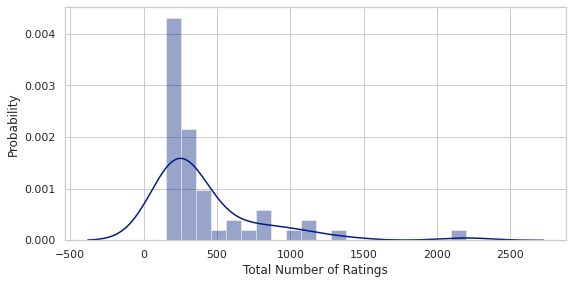

4023

In [11]:
pop10 = meta.sort_values('overall_count', ascending = False).head(50)
plt.figure(figsize=(8,4))
sns.distplot(pop10['overall_count'], bins=20)
plt.xlabel('Total Number of Ratings')
plt.ylabel('Probability')
plt.show()
del pop10
gc.collect()

array([<AxesSubplot:title={'center':'False'}>,
       <AxesSubplot:title={'center':'True'}>], dtype=object)

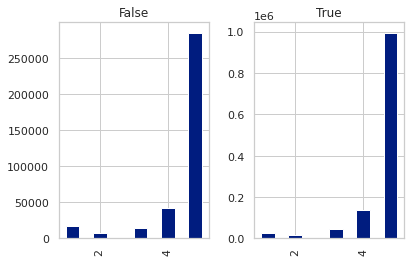

In [12]:
# review_df['verified'] = review_df['verified'].astype(int)
# sns.jointplot(x = 'verified', y = 'overall', data = review_df, s = 5)

review_df['overall'].hist(by=review_df['verified'])
# review_df = review_df.drop('verified', axis = 1)

In [13]:
# meta[meta['overall_count'] >= 10].sort_values('overall_mean', ascending = False).head(10)
print('Total No. of users that gave rating of 5.0 : ', len(meta.loc[meta['overall_mean'] == 5]), '\n')
print('Total No. of Single users that gave rating of 5.0 : ', len(meta.loc[(meta['overall_mean'] == 5)]))

Total No. of users that gave rating of 5.0 :  47698 

Total No. of Single users that gave rating of 5.0 :  47698


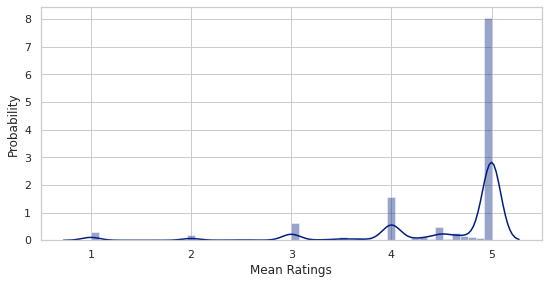

In [14]:
plt.figure(figsize=(8,4))
sns.distplot(meta['overall_mean'], bins=50)
plt.xlabel('Mean Ratings')
plt.ylabel('Probability')
plt.show()

Text(352.7085714285715, 0.5, 'Ratings Counts')

<Figure size 864x864 with 0 Axes>

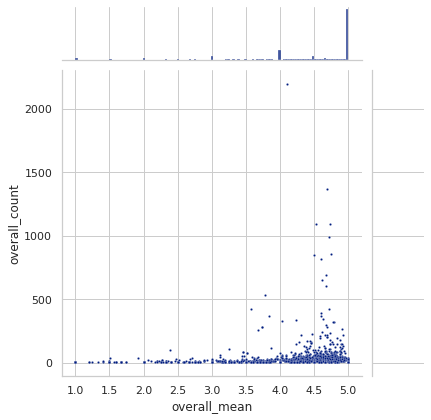

In [15]:
plt.figure(figsize=(12,12))
sns.jointplot(x = 'overall_mean', y = 'overall_count', data = meta, s = 5)
plt.xlabel('Mean Ratings')
plt.ylabel('Ratings Counts')

## Merge Datasets

In [16]:
df = review_df.merge(meta, on = 'asin')
df
# df[df['reviewerID'] == 'AC2PL52NKPL29']

,reviewerID,overall,reviewText,asin,summary,day_of_week,style,verified,title,also_buy,brand,rank,also_view,price,buy_count,view_count,overall_mean,overall_median,overall_count
0,A1ZCPG3D3HGRSS,5,this is great cd full of worship favorites all time great keith green songs his best album by far,0001388703,great worship cd,6,Audio CD,True,So You Wanna Go Back to Egypt,"[B0000275QQ, 0001393774, 0001388312, B0016CP2GS, B00P826ZRM, 1595551646, B0001YY7P4, B00000I7JO, B00000I9AH, B0000047XZ, B000075A86, B07896NHMK, B0002EZZMC, B0000031DI, B000008KJ8, 0793579805]",keith green,203263.0,"[B00000I7JO, B0016CP2GS, 0001393774, B0000275QQ, B00000I9AH, B0001YY7P4, B0002EZZMC, B00P826ZRM, B000OJKH78, B000075A86, B00412UE18, B000000V4U]",13.01,16,12,4.571429,5.0,28
1,AC2PL52NKPL29,5,so creative love his music the words the message some of my favorite songs on this cd should have bought it years ago,0001388703,gotta listen to this,2,Audio CD,True,So You Wanna Go Back to Egypt,"[B0000275QQ, 0001393774, 0001388312, B0016CP2GS, B00P826ZRM, 1595551646, B0001YY7P4, B00000I7JO, B00000I9AH, B0000047XZ, B000075A86, B07896NHMK, B0002EZZMC, B0000031DI, B000008KJ8, 0793579805]",keith green,203263.0,"[B00000I7JO, B0016CP2GS, 0001393774, B0000275QQ, B00000I9AH, B0001YY7P4, B0002EZZMC, B00P826ZRM, B000OJKH78, B000075A86, B00412UE18, B000000V4U]",13.01,16,12,4.571429,5.0,28
2,A1SUZXBDZSDQ3A,5,keith green gone far to early in his carreer left us with these few golden alblums to bless us and let us see from more in sync world veiw or should say the language of the modern world had th...,0001388703,great approach still gets the message out,5,Audio CD,True,So You Wanna Go Back to Egypt,"[B0000275QQ, 0001393774, 0001388312, B0016CP2GS, B00P826ZRM, 1595551646, B0001YY7P4, B00000I7JO, B00000I9AH, B0000047XZ, B000075A86, B07896NHMK, B0002EZZMC, B0000031DI, B000008KJ8, 0793579805]",keith green,203263.0,"[B00000I7JO, B0016CP2GS, 0001393774, B0000275QQ, B00000I9AH, B0001YY7P4, B0002EZZMC, B00P826ZRM, B000OJKH78, B000075A86, B00412UE18, B000000V4U]",13.01,16,12,4.571429,5.0,28
3,A3A0W7FZXM0IZW,5,keith green had his special comedy style of chirstian music with powerful message came quickly and packaged well would purchase from this vendor again,0001388703,great must have,6,Audio CD,True,So You Wanna Go Back to Egypt,"[B0000275QQ, 0001393774, 0001388312, B0016CP2GS, B00P826ZRM, 1595551646, B0001YY7P4, B00000I7JO, B00000I9AH, B0000047XZ, B000075A86, B07896NHMK, B0002EZZMC, B0000031DI, B000008KJ8, 0793579805]",keith green,203263.0,"[B00000I7JO, B0016CP2GS, 0001393774, B0000275QQ, B00000I9AH, B0001YY7P4, B0002EZZMC, B00P826ZRM, B000OJKH78, B000075A86, B00412UE18, B000000V4U]",13.01,16,12,4.571429,5.0,28
4,A12R54MKO17TW0,5,keith green so you wanna go back to egypt in this album keith gets his serious messages across with some of the best examples of his wonderful humor bob dylan plays harmonica on this album ...,0001388703,a great one from keith with guest appearance by bob dylan,5,Audio CD,False,So You Wanna Go Back to Egypt,"[B0000275QQ, 0001393774, 0001388312, B0016CP2GS, B00P826ZRM, 1595551646, B0001YY7P4, B00000I7JO, B00000I9AH, B0000047XZ, B000075A86, B07896NHMK, B0002EZZMC, B0000031DI, B000008KJ8, 0793579805]",keith green,203263.0,"[B00000I7JO, B0016CP2GS, 0001393774, B0000275QQ, B00000I9AH, B0001YY7P4, B0002EZZMC, B00P826ZRM, B000OJKH78, B000075A86, B00412UE18, B000000V4U]",13.01,16,12,4.571429,5.0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182821,A11GYQ5Y9GHH0Z,5,wonderful,B01HHRIKKK,five stars,3,Audio CD,True,EXO - EX'ACT 3rd Album [Korean Lucky One Version] CD with 124page Photobook+1 Photocard (Random),"[B07HSM242F, B00VMJ1MMS, B077ZYR799, B00YSOAJGE, B075D9V4WV, B07L2S4YVG, B00JOZWJX8, B07L2VYW5M, B01KNSVGKQ, B07HGQ4FPP, B00MEG38QG, B00YUOSN60, B07BPTT22C, B00MEH4AU8, B0757DFP6W, B007RBKZRI, B01...",exo,130165.0,"[B07HSM242F, B01KNSVGKQ, B077ZYR799, B075D9V4WV, B00VMJ1MMS, B00YSOAJGE, B00JOZWJX8, B073VBWR4J, B00MEG38QG, B00ME

In [17]:
df[['reviewerID','asin','title','overall','brand','style','summary','reviewText','price','overall_median']].nunique()

reviewerID        127174
asin               66010
title              59573
overall                5
brand              34884
style                 28
summary           102182
reviewText        150926
price               5553
overall_median         9
dtype: int64

In [18]:
df.isnull().sum()

reviewerID            0
overall               0
reviewText            0
asin                  0
summary               0
day_of_week           0
style             39648
verified              0
title                 0
also_buy              0
brand                 0
rank              11111
also_view             0
price             68501
buy_count             0
view_count            0
overall_mean          0
overall_median        0
overall_count         0
dtype: int64

### 2.2) EDA - Collaberative Filtering 

#### Model without Deep Learning - Get trainset

In [19]:
train = df[['reviewerID','asin','overall']][:10000]
train

,reviewerID,asin,overall
0,A1ZCPG3D3HGRSS,0001388703,5
1,AC2PL52NKPL29,0001388703,5
2,A1SUZXBDZSDQ3A,0001388703,5
3,A3A0W7FZXM0IZW,0001388703,5
4,A12R54MKO17TW0,0001388703,5
...,...,...,...
9995,AC4XV78EJG1QB,B0002EWGV0,5
9996,AC4XV78EJG1QB,B0002EWGV0,5
9997,A3XZFPYS1OKN0,B0002EWGV0,5
9998,A3XZFPYS1OKN0,B0002EWGV0,5


#### Model without Deep Learning - Vectorizing our features

In [20]:
# train_, test_ = train_test_split(train, 0.4)
train_matrix = train.pivot_table(values='overall', index='reviewerID', columns='asin')
del train
gc.collect()
print(train_matrix.shape)
train_matrix.head()

(7346, 200)


asin,0001377647,0001388703,0001526146,0001527134,0006920055,0006935257,0615897398,0760103453,0760131694,0760135886,0830838015,0875420230,0879465298,0966484525,1424338441,1561025089,1584591641,1584593377,1880878151,1881405915,1882513274,1929243464,1932192077,1937509095,278472414X,3236514752,3426958910,4901000616,5550312085,5552256646,5552424034,5553860377,5557386823,5557416978,555757266X,5557575758,5557585400,5557706259,5557721835,5558154950,555820690X,5558269448,5558433892,5558738065,5558870850,5558925922,5559166928,5559571814,555975479X,6302603420,7019098606,7472007722,7474023105,7474051877,7799420340,9314510573,9490497045,9714721180,B0000004EP,B0000024P7,B000002TTH,B0000041EV,B0000041RT,B000006045,B000006XAN,B00000747R,B000007PC8,B000007TVG,B000007UVW,B000007W4Z,B000007Y0H,B0000085KY,B000008M8Z,B000009D3S,B00000B16Q,B00000EWWG,B00000G4QD,B00000GWZZ,B00000I49U,B00000I6WY,B00000I7LP,B00000I8FQ,B00000IGG3,B00000IMM0,B00000IZOM,B00000JF6K,B00000JN4K,B00000JWON,B00000JXPT,B00000K2IH,B00001U08E,B00001WRJI,B0000241JO,B000024BID,B0000251VF,B000025V1P,B000025WB0,B000025Y5D,B00002838I,B0000287BK,B00002EQDG,B00002MHU1,B00002MY88,B00002SSLS,B00003G1SC,B00003GOHN,B00003OTHZ,B00003Q002,B00003TL2A,B00004LMDK,B00004SUC7,B00004SYUX,B00004TTUZ,B00004UEHA,B00004UZC9,B00004WPC6,B00004Y309,B00004YKE2,B000050I9U,B00005249T,B0000564WK,B0000565FJ,B000056BP0,B000056IIG,B000056OYF,B000056XHA,B000057C4M,B000057S59,B00005A83L,B00005ATWP,B00005AUXY,B00005BIB2,B00005J8W3,B00005L9FU,B00005NZ50,B00005O4U7,B00005QBZX,B00005R0AL,B00005U1WP,B00005U5SG,B00005UBNB,B00005UMAE,B00005V6EF,B0000657TI,B000067DXJ,B000067E2F,B000068C7V,B00006BN11,B00006LJ9R,B00006ZUNQ,B000085U0I,B00008GSAW,B00008MHCN,B00008PVXH,B00008V71J,B000091XK5,B0000929PF,B000095J68,B0000AMKBI,B0000AOHL1,B0000AV39Q,B0000B12A9,B0000C2VRW,B0000DIIBJ,B0000DZBV5,B0000TW3UG,B00012CTTM,B00015BIOQ,B00015BOZY,B00015V5A8,B0001D6LSQ,B0001EK4TC,B0001FFK90,B0001FLT2C,B0001GIE1K,B0001GZ8CS,B0001KOWO4,B0001MR172,B0001PICSG,B0001WW4H4,B0001X0UBA,B0001XXAVM,B0001Y7HTW,B0001ZWBK6,B00020JJ3W,B00020VQUQ,B00021Z7TQ,B000229MVY,B00022OASY,B00025G1H4,B00025HD9E,B0002847MM,B000289SSA,B000295T8W,B0002A5B6G,B0002AAPR6,B0002ATFF4,B0002BGOAM,B0002BIBGC,B0002EWGV0
reviewerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A06818207QDXOKXENCIB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10002EO9ZUY0B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [21]:
item_util_matrix = train_matrix.apply(lambda col : col.fillna(col.mean()), axis=0)
item_util_matrix.head(5)
del train_matrix
gc.collect()
item_corr_matrix = item_util_matrix.corr()
item_corr_matrix
del item_util_matrix
gc.collect()

0

There are lot of NaN values and that is because when we are calculating the Pearson correlation, if the rating vector has all the values same for eg -> [3.0 , 3.0, 3.0, 3.0, ....], then the Standard Deviation is zero and division by zero is undefined, and thus its correlation with any other rating vector is NaN.

Since there are many movies that are rated only by 1 user , there the whole column mean is filled with the rating of that user, and therefore it's Pearson correlation gives NaN values with any other column.

#### Model without Deep Learning - Test our basic recommender system & Get the Results

In [22]:
i_corr = item_corr_matrix['555820690X'].sort_values(ascending=False)
i_corr.dropna(inplace=True)
album_similar_to_i = pd.DataFrame(data=i_corr.values, columns=['Correlation'], index = i_corr.index)
album_similar_to_i.head(10).merge(meta, on = 'asin')[['asin','title','Correlation','brand','overall_mean','overall_count']]
# album_similar_to_i.tail(10).merge(meta, on = 'asin')[['asin','title','Correlation','brand','overall_mean','overall_count']]

,asin,title,Correlation,brand,overall_mean,overall_count
0,555820690X,The Ultimate Collection,1.000000e+00,john michael talbot,4.700000,70
1,9714721180,"<span class=""a-size-medium a-color-secondary a-text-normal""",8.538006e-03,metallica,4.723404,987
2,0760135886,Don Francisco,3.761281e-03,don francisco,4.880000,25
3,0006935257,The Lord's Supper / Be Exalted,3.602278e-03,john michael talbot,4.853659,41
4,9490497045,Live On Earth,2.122866e-14,omnia,4.900000,20
5,B00025HD9E,Bubba Ho-Tep Signature Edition,1.807724e-14,brian tyler,4.833333,12
6,B00025HD9E,Bubba Ho-Tep Signature Edition,1.807724e-14,brian tyler,4.833333,12
7,B000056XHA,What's Up ? Audio 4 Non Blondes,1.353083e-14,4 non blondes,4.666667,12
8,B000056XHA,What's Up ? Audio 4 Non Blondes,1.353083e-14,4 non blondes,4.666667,12
9,B0001XXAVM,Repeat the Sounding Joy Audio Glenn Close; Placido Domingo; Ambrosian Singers and The London Symphony Orchestra,1.061709e-14,glenn close,4.722222,18


## 3) Sentiment Analysis
Reminder:
* Music: 'asin','style','title','brand', 'rank','price','overall_mean','overall_median','overall_count'
* User Review: 'asin','reviewerID','overall','reviewText','summary','day_of_week'

In [23]:
dl_train = df[['reviewerID', 'overall', 'reviewText', 'asin', 'summary', 'day_of_week','verified',
               'style', 'title', 'brand', 'rank', 'price', 'overall_mean', 'overall_median', 'overall_count']]

print(dl_train.shape)
dl_train.head(5)

(182826, 15)


,reviewerID,overall,reviewText,asin,summary,day_of_week,verified,style,title,brand,rank,price,overall_mean,overall_median,overall_count
0,A1ZCPG3D3HGRSS,5,this is great cd full of worship favorites all time great keith green songs his best album by far,0001388703,great worship cd,6,True,Audio CD,So You Wanna Go Back to Egypt,keith green,203263.0,13.01,4.571429,5.0,28
1,AC2PL52NKPL29,5,so creative love his music the words the message some of my favorite songs on this cd should have bought it years ago,0001388703,gotta listen to this,2,True,Audio CD,So You Wanna Go Back to Egypt,keith green,203263.0,13.01,4.571429,5.0,28
2,A1SUZXBDZSDQ3A,5,keith green gone far to early in his carreer left us with these few golden alblums to bless us and let us see from more in sync world veiw or should say the language of the modern world had th...,0001388703,great approach still gets the message out,5,True,Audio CD,So You Wanna Go Back to Egypt,keith green,203263.0,13.01,4.571429,5.0,28
3,A3A0W7FZXM0IZW,5,keith green had his special comedy style of chirstian music with powerful message came quickly and packaged well would purchase from this vendor again,0001388703,great must have,6,True,Audio CD,So You Wanna Go Back to Egypt,keith green,203263.0,13.01,4.571429,5.0,28
4,A12R54MKO17TW0,5,keith green so you wanna go back to egypt in this album keith gets his serious messages across with some of the best examples of his wonderful humor bob dylan plays harmonica on this album ...,0001388703,a great one from keith with guest appearance by bob dylan,5,False,Audio CD,So You Wanna Go Back to Egypt,keith green,203263.0,13.01,4.571429,5.0,28


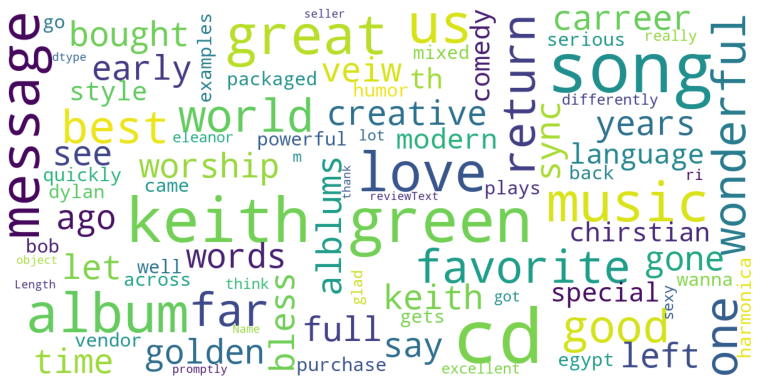

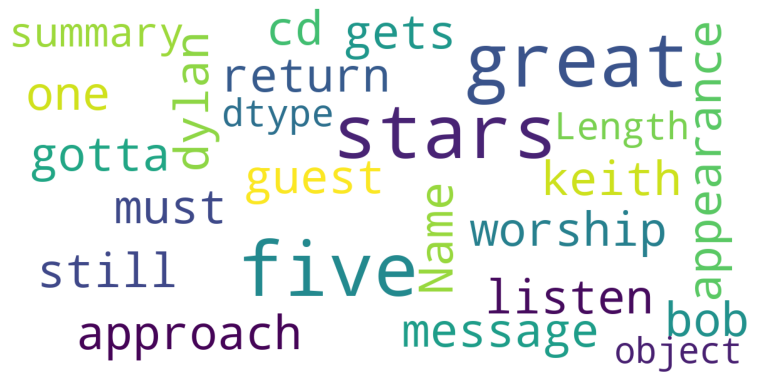

CPU times: user 1.22 s, sys: 322 ms, total: 1.54 s
Wall time: 1.09 s


In [24]:
%%time
#--- WordCloud
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(background_color='white', stopwords=stopwords, 
                          max_words=200, max_font_size=40, scale=3, 
                          random_state=1).generate(str(data))
    fig = plt.figure(1, figsize=(12, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(dl_train['reviewText'])
print()
print()
# print("Word Cloud processing completed in ")
show_wordcloud(dl_train['summary'])

### Deep Learning Model for Review Texts Sentiment Analysis


#### Tokenizing

In [25]:
def sentiments(df):
    if df['overall'] > 3.0:
        return 'Positive'
    elif df['overall'] <= 3.0:
        return 'Negative'
dl_train['attitude'] = dl_train.apply(sentiments, axis=1)
# sent_dl_train =sent_dl_train.drop_duplicates()

print(dl_train.shape)
dl_train.head(1)

(182826, 16)


,reviewerID,overall,reviewText,asin,summary,day_of_week,verified,style,title,brand,rank,price,overall_mean,overall_median,overall_count,attitude
0,A1ZCPG3D3HGRSS,5,this is great cd full of worship favorites all time great keith green songs his best album by far,0001388703,great worship cd,6,True,Audio CD,So You Wanna Go Back to Egypt,keith green,203263.0,13.01,4.571429,5.0,28,Positive


In [26]:
dl_train[['attitude','overall','summary']].head(5)

,attitude,overall,summary
0,Positive,5,great worship cd
1,Positive,5,gotta listen to this
2,Positive,5,great approach still gets the message out
3,Positive,5,great must have
4,Positive,5,a great one from keith with guest appearance by bob dylan


In [27]:
tokenizer = Tokenizer(num_words=100, split = ' ') 
tokenizer.fit_on_texts(dl_train['summary'].values)

X = tokenizer.texts_to_sequences(dl_train['summary'].values)
X = pad_sequences(X)
print(X.shape)

(182826, 20)


Here I use a simple deep network configuration. 

The model during training shall learn the word embeddings from the input text. The total trainable params are 191,860. The output shape is 2 which corresponds to the positive (> 3 stars) and negative label (<= 3 stars) in the 5-star range.

After some tryouts, I embed the summary texts for the top 100 words. Then, I use a Convolutional Neural Network (CNN) as they have proven to be successful at document classification problems. A conservative CNN configuration is used with 128 filters (parallel fields for processing words) and a kernel size of 8 with a rectified linear (‘relu’) activation function. This is followed by a pooling layer that reduces the output of the convolutional layer by half.

Next, the 2D output from the CNN part of the model is flattened to one long 2D vector to represent the ‘features’ extracted by the CNN. The back-end of the model is a standard Multilayer Perceptron layers to interpret the CNN features. The output layer uses a sigmoid activation function to output a value between 0 and 1 for the negative and positive sentiment in the review.

In [28]:
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Embedding, Dense
# define model
model2 = models.Sequential()
model2.add(Embedding(100, 150, input_length=X.shape[1]))
model2.add(Conv1D(filters=128, kernel_size=8, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(layers.Flatten())
model2.add(Dense(30, activation='relu'))
model2.add(Dense(2, activation='sigmoid'))
print(model2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 150)           15000     
_________________________________________________________________
conv1d (Conv1D)              (None, 13, 128)           153728    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 30)                23070     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 62        
Total params: 191,860
Trainable params: 191,860
Non-trainable params: 0
__________________________________________________

2022-08-06 06:11:20.941461: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [29]:
# compile network
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','binary_crossentropy'])
y = pd.get_dummies(dl_train['attitude'])

hist = model2.fit(X, y, validation_split=0.3, epochs = 10, batch_size = 16, verbose = 'auto')

2022-08-06 06:11:21.273194: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
7999/7999 [==============================] - 63s 8ms/step - loss: 0.2929 - accuracy: 0.8976 - binary_crossentropy: 0.2929 - val_loss: 0.2542 - val_accuracy: 0.9145 - val_binary_crossentropy: 0.2542
Epoch 2/10
7999/7999 [==============================] - 65s 8ms/step - loss: 0.2832 - accuracy: 0.9001 - binary_crossentropy: 0.2832 - val_loss: 0.2547 - val_accuracy: 0.9149 - val_binary_crossentropy: 0.2547
Epoch 3/10
7999/7999 [==============================] - 60s 8ms/step - loss: 0.2798 - accuracy: 0.9012 - binary_crossentropy: 0.2798 - val_loss: 0.2512 - val_accuracy: 0.9143 - val_binary_crossentropy: 0.2512
Epoch 4/10
7999/7999 [==============================] - 62s 8ms/step - loss: 0.2760 - accuracy: 0.9021 - binary_crossentropy: 0.2760 - val_loss: 0.2522 - val_accuracy: 0.9147 - val_binary_crossentropy: 0.2522
Epoch 5/10
7999/7999 [==============================] - 62s 8ms/step - loss: 0.2721 - accuracy: 0.9036 - binary_crossentropy: 0.2721 - val_loss: 0.2585 - val_accura

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
model2.evaluate(X_test,y_test)

1714/1714 [==============================] - 6s 3ms/step - loss: 0.2652 - accuracy: 0.9115 - binary_crossentropy: 0.2652


[0.2651936709880829, 0.9114643931388855, 0.2651936709880829]

#### The final model has the test accuracy 91.4%


dict_keys(['loss', 'accuracy', 'binary_crossentropy', 'val_loss', 'val_accuracy', 'val_binary_crossentropy'])


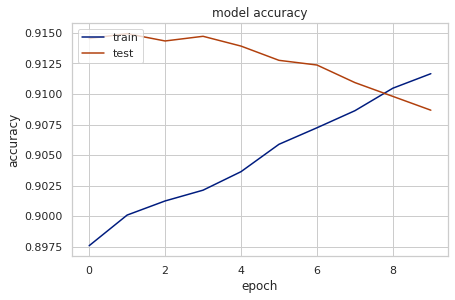

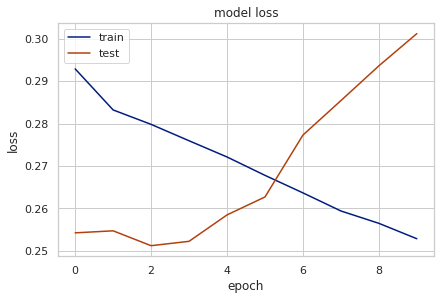

In [31]:
print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<!-- Here I build a LSTM model for classifying the sentiments for these review into 5-star categories. -->

In [32]:
# from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
# model = models.Sequential()
# model.add(Embedding(30, 50, input_length = X.shape[1]))
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(2, activation='softmax'))
# model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
# print(model.summary())
# model.fit(X_train, y_train, epochs = 5, batch_size = 32, verbose = 'auto')
# model.evaluate(X_test,y_test)

In [33]:
# tokenizer = Tokenizer(num_words=100, split = ' ') 
# tokenizer.fit_on_texts(sent_dl_train['summary'].values)

# X = tokenizer.texts_to_sequences(sent_dl_train['summary'].values)
# X = pad_sequences(X)
# print(X.shape)

# sample_1 = "waste of money"
# sample_2 = "average song"
# sample_3 = "worst cd ever"
# sample_4 = "five star bad"
# sample_5 = "favorite album"
# sample_5 = "great"

# samples = np.array([sample_1,sample_2,sample_3,sample_4,sample_5])
# # tokenizer.fit_on_texts(samples)
# samples_tokens = tokenizer.texts_to_sequences(samples)
# samples_tokens_pad = pad_sequences(samples_tokens)
# #predict
# # 
# print(samples_tokens_pad.shape)
# model2.predict(samples_tokens_pad)

## 4) Collaberative Filtering - Deep Learning

In [34]:
sentiment = pd.DataFrame(X)
sentiment = np.log(sentiment.replace(0, np.nan))
sentiment = sentiment.rename(columns=lambda x: 'review_' + str(x))
dl_train = dl_train.join(sentiment)
dl_train['price']=np.log(dl_train['price'])
dl_train['overall_count'] = np.log(dl_train['overall_count'])
dl_train['overall_mean'] = np.log(dl_train['overall_mean'])
dl_train = dl_train.fillna(0)

In [35]:
# dl_train.nunique()

In [36]:
final_dl_train = dl_train.drop(['summary', 'reviewText','attitude','title','brand','rank'], axis = 1)
final_dl_train = pd.get_dummies(final_dl_train, columns=['day_of_week','verified','style','overall_median'])
final_dl_train.head(1)

,reviewerID,overall,asin,price,overall_mean,overall_count,review_0,review_1,review_2,review_3,review_4,review_5,review_6,review_7,review_8,review_9,review_10,review_11,review_12,review_13,review_14,review_15,review_16,review_17,review_18,review_19,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,verified_False,verified_True,style_0,style_Accessory,style_Amazon Video,style_Apparel,style_Audible Audiobook,style_Audio CD,style_Audio Cassette,style_CD Video,style_Calendar,style_DVD,style_DVD Audio,style_Grocery,style_Hardcover,style_Kindle Edition,style_Kitchen,style_Laser Disc,style_MP3 CD,style_MP3 Music,style_Office Product,style_Paperback,style_Perfect Paperback,style_Personal Computers,style_Prime Video,style_Unbound,style_Unknown Binding,style_VHS Tape,style_Video CD,style_Vinyl,style_Vinyl Bound,overall_median_1.0,overall_median_1.5,overall_median_2.0,overall_median_2.5,overall_median_3.0,overall_median_3.5,overall_median_4.0,overall_median_4.5,overall_median_5.0
0,A1ZCPG3D3HGRSS,5,0001388703,2.565718,1.519826,3.332205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.386294,2.197225,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [37]:
# final_dl_train.columns

In [38]:
X = np.array(final_dl_train[['price', 'overall_mean', 'overall_count', 'review_0', 'review_1', 'review_2', 'review_3', 'review_4', 'review_5', 'review_6', 'review_7', 'review_8', 'review_9', 'review_10', 'review_11', 'review_12', 'review_13', 'review_14', 'review_15', 'review_16', 'review_17', 'review_18', 'review_19', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'verified_False', 'verified_True', 'style_0', 'style_Accessory', 'style_Amazon Video', 'style_Apparel', 'style_Audible Audiobook', 'style_Audio CD', 'style_Audio Cassette', 'style_CD Video', 'style_Calendar', 'style_DVD', 'style_DVD Audio', 'style_Grocery', 'style_Hardcover', 'style_Kindle Edition', 'style_Kitchen', 'style_Laser Disc', 'style_MP3 CD', 'style_MP3 Music', 'style_Office Product', 'style_Paperback', 'style_Perfect Paperback', 'style_Personal Computers', 'style_Prime Video', 'style_Unbound', 'style_Unknown Binding',
       'style_VHS Tape', 'style_Video CD', 'style_Vinyl', 'style_Vinyl Bound', 'overall_median_1.0', 'overall_median_1.5', 'overall_median_2.0', 'overall_median_2.5', 'overall_median_3.0', 'overall_median_3.5', 'overall_median_4.0', 'overall_median_4.5', 'overall_median_5.0']])
y = final_dl_train[['overall']]
y['a'] = y['overall'] + 0.2
y['c'] = y['overall'] - 0.2
y = y.values
y

array([[5. , 5.2, 4.8],
       [5. , 5.2, 4.8],
       [5. , 5.2, 4.8],
       ...,
       [5. , 5.2, 4.8],
       [5. , 5.2, 4.8],
       [5. , 5.2, 4.8]])

In [39]:
sc = StandardScaler()
X_std = sc.fit_transform(X)
print(X_std.shape)
print(y.shape)

(182826, 70)
(182826, 3)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.33, random_state=42)

## Autoencoder

In [41]:
from tensorflow import keras
from tensorflow.keras import optimizers
from keras import models, layers

encoder = models.Sequential([layers.Dense(5, input_shape=[70,])])
decoder = models.Sequential([layers.Dense(70, input_shape=[5])])
autocoder = models.Sequential([encoder, decoder])
print(autocoder.summary())

autocoder.compile(loss = 'mse', optimizer = optimizers.SGD(lr = 0.0001))


history = autocoder.fit(X_train, X_train, epochs = 10, 
                     validation_data=(X_test, X_test))
codings = encoder.predict(X_train)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 5)                 355       
_________________________________________________________________
sequential_2 (Sequential)    (None, 70)                420       
Total params: 775
Trainable params: 775
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3828/3828 [==============================] - 6s 2ms/step - loss: 1.2482 - val_loss: 1.1966
Epoch 2/10
3828/3828 [==============================] - 6s 2ms/step - loss: 1.2173 - val_loss: 1.1714
Epoch 3/10
3828/3828 [==============================] - 6s 2ms/step - loss: 1.1912 - val_loss: 1.1500
Epoch 4/10
3828/3828 [==============================] - 6s 2ms/step - loss: 1.1688 - val_loss: 1.1315
Epoch 5/10
3828/3828 [==============================] - 6s 2ms/step - loss: 1.1494 - val_loss: 1.1153
Epo

dict_keys(['loss', 'val_loss'])


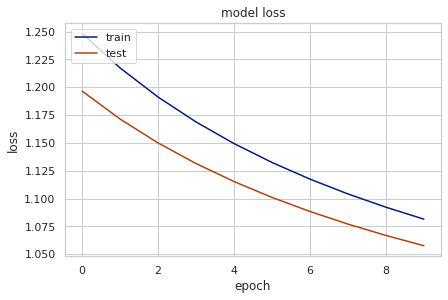

In [42]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
y_ori = final_dl_train['overall'].values

In [44]:
# plt.figure(figsize=(8,8))
# plt.title('PCA')
# classes = range(5)
# colors = ['red', 'blue', 'yellow', 'green', 'orange']

# for color, i in zip(colors, classes):
#     plt.scatter(codings[:,0][y_ori == i], 
#                 codings[:,1][y_ori == i],
#                 color=color, alpha=1.,
#                 label=i, s = 0.8)
# plt.legend() 
# plt.xlabel("Z1")
# plt.ylabel("Z2")
# plt.show()

In [45]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization, Dense
model = models.Sequential()
model.add(Dense(256, activation='relu', 
                input_dim=X_train.shape[1], activity_regularizer=regularizers.l1(0.01)))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               18176     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_7 (Dense)              (None, 32)               

In [46]:
history = model.fit(X_std, y_ori, validation_split=0.3, epochs = 10, batch_size = 32, verbose = 'auto')

Epoch 1/10
4000/4000 [==============================] - 24s 5ms/step - loss: 2.0719 - mae: 0.8148 - val_loss: 1.2415 - val_mae: 0.6192
Epoch 2/10
4000/4000 [==============================] - 21s 5ms/step - loss: 0.6553 - mae: 0.4639 - val_loss: 975.3854 - val_mae: 0.9285
Epoch 3/10
4000/4000 [==============================] - 22s 5ms/step - loss: 0.6283 - mae: 0.4553 - val_loss: 24.8035 - val_mae: 0.4325
Epoch 4/10
4000/4000 [==============================] - 21s 5ms/step - loss: 0.6147 - mae: 0.4504 - val_loss: 9.6386 - val_mae: 0.3883
Epoch 5/10
4000/4000 [==============================] - 22s 5ms/step - loss: 0.6086 - mae: 0.4474 - val_loss: 247.2344 - val_mae: 0.5574
Epoch 6/10
4000/4000 [==============================] - 22s 5ms/step - loss: 0.6024 - mae: 0.4463 - val_loss: 13.2175 - val_mae: 0.3390
Epoch 7/10
4000/4000 [==============================] - 21s 5ms/step - loss: 0.5964 - mae: 0.4440 - val_loss: 2.3107 - val_mae: 0.3045
Epoch 8/10
4000/4000 [===========================

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


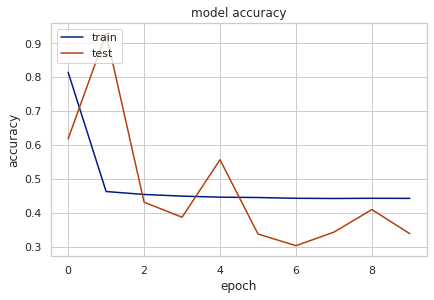

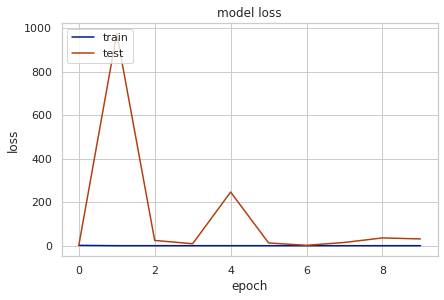

In [47]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
# dtf_users = final_dl_train.pivot_table(index="reviewerID", columns="asin")

## Testing our recommender System

In [49]:
reconstructed = autocoder.predict(X_std)

y_pred_auto = model.predict(reconstructed)
y_pred = model.predict(X_std)

In [50]:
predictions_auto = np.array([a[0] for a in y_pred_auto])
predictions = np.array([a[0] for a in y_pred])
predictions

array([4.537903 , 4.500707 , 4.5806427, ..., 5.008701 , 5.004421 ,
       4.9960923], dtype=float32)

In [51]:
recommended_book_ids = (-predictions).argsort()[:5]
recommended_book_ids2 = (-predictions_auto).argsort()[:5]

In [52]:
print(recommended_book_ids)
print(recommended_book_ids2)
print(predictions[recommended_book_ids])
print(predictions[recommended_book_ids2])

[157328 139876 158157 172714 172713]
[122303 174430 158157 145631 128210]
[445.45532 432.15503 385.6538  309.70227 309.3977 ]
[ 13.076292 254.94537  385.6538   240.7586   243.45203 ]


In [53]:
res = dl_train.iloc[recommended_book_ids]['title'].tolist() + dl_train.iloc[recommended_book_ids2]['title'].tolist()
print(res)


['Harry Potter Official 2017 Square Calendar', 'Head Over Heels - C.D.Video', 'the lonely side of the city', '<span class="a-size-medium a-color-secondary a-text-normal"', '<span class="a-size-medium a-color-secondary a-text-normal"', 'J.K,LISTEN, Songs of Presence; The Monks of Weston Priory; Weston Priory Productions, XPL-1050, 1973.,Weston Priory Productions" />', 'Live In Montreux 1970', 'the lonely side of the city', 'Loud Distribution - Bruce Springsteen T-Shirt Wrecking Ball Size L', '<span class="a-size-medium a-color-secondary a-text-normal"']
